In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import sklearn

In [28]:
# Read the data from the CSV file
data = pd.read_csv('train_data_combined.csv')

# Convert the 'Coordinates' and 'Order' columns from strings to actual arrays
data['Coordinates'] = data['Coordinates'].apply(ast.literal_eval)
data['Order'] = data['Order'].apply(ast.literal_eval)


In [29]:
def normalize(coords):
    # coords_string = row['Coordinates']
    # coords = ast.literal_eval(coords_string)
    scaler = sklearn.preprocessing.MinMaxScaler()
    coords = scaler.fit_transform(coords)
    return coords

data['Coordinates'] = data['Coordinates'].apply(normalize)


def dist_matrix(cords):
    return sp.spatial.distance.cdist(cords, cords)

data['distance_matrix'] = data['Coordinates'].apply(dist_matrix)
data.head()

for i in range(len(data['distance_matrix'])):
    current_cords = data['Coordinates'][i]
    current_order = data['Order'][i]
    id = data['Id'][i]
    # print(current_cords)
    tmp_dist = np.sum([np.sqrt((current_cords[current_order[j]]).dot(current_cords[current_order[j-1]])) for j in range(1,len(current_cords))])
    # print(tmp_dist)
    # data["Distance"][i] = tmp_dist

    data.loc[data['Id'] == id, 'Distance'] = tmp_dist

data.head()


,Id,Coordinates,Order,Distance,Time,distance_matrix
0,1,"[[0.0, 0.0], [0.7777777777777778, 0.9537572254...","[0, 4, 9, 18, 17, 11, 20, 19, 10, 7, 13, 1, 15...",16.728140,13.537999,"[[0.0, 1.2306872538023605, 1.234640485676661, ..."
1,2,"[[0.0, 0.0], [0.2727272727272727, 0.1587301587...","[0, 17, 1, 16, 12, 2, 6, 18, 15, 11, 3, 4, 10,...",16.587638,16.687000,"[[0.0, 0.31555574559775895, 0.9387830696579602..."
2,3,"[[0.0, 0.0], [0.46153846153846156, 0.428571428...","[0, 10, 18, 1, 11, 7, 4, 13, 12, 20, 6, 9, 16,...",17.408139,15.678530,"[[0.0, 0.629834280479433, 0.4738115061034553, ..."
3,4,"[[0.0, 0.0], [0.865079365079365, 0.07317073170...","[0, 9, 19, 10, 14, 16, 11, 7, 20, 17, 18, 12, ...",15.854547,16.803660,"[[0.0, 0.8681683384371383, 0.5257502820685432,..."
4,5,"[[0.0, 0.0], [0.0963855421686747, 0.9999999999...","[0, 15, 20, 12, 11, 17, 19, 6, 18, 2, 5, 3, 9,...",17.022070,17.877002,"[[0.0, 1.004634347779902, 0.8478336251124811, ..."


In [30]:
def stack(input):
    input = np.array(input)
    return np.hstack((input[:,0],input[:,1]))

data["Cords_stacked"] = data["Coordinates"].apply(stack)
data["results_stacked"] = data["Cords_stacked"]

tmp_cords = data["Coordinates"].to_numpy()
indices = data["Order"].to_numpy()

results_stacked = []
for i in range(len(data["Cords_stacked"])):
    index = np.array(indices[i], dtype=np.int64)
    tmp_cords = np.array(data["Coordinates"].to_numpy()[i])
    tmp_result =  np.hstack((np.array(tmp_cords[:,0])[index],np.array(tmp_cords[:,1])[index]))
    results_stacked.append(tmp_result)

results_stacked = np.array(results_stacked, dtype=np.float32)



In [31]:
class ConvNet(nn.Module):
    def __init__(self, in_channels=1, conv1_out_channels=32, conv2_out_channels=64, fc1_out_features=128, hidden_size=256, output_size=44, additional_input_size=44):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, conv1_out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(conv1_out_channels, conv2_out_channels, kernel_size=3, stride=1, padding=1)
        
        # Calculate the size of the flattened layer after convolutions
        self.conv_output_size = conv2_out_channels * 22 * 22
        
        # The total input size for the first fully connected layer includes the additional input values
        self.fc1_input_size = self.conv_output_size + additional_input_size
        
        # Define fully connected layers
        self.fc1 = nn.Linear(self.fc1_input_size, fc1_out_features)
        self.fc2 = nn.Linear(fc1_out_features, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
            
    def forward(self, image, additional_input):
        # x = F.relu(self.conv1(image))
        # x = F.relu(self.conv2(x))
        # x = x.view(-1, self.conv_output_size)  # Flatten the tensor
        # x = torch.cat((x, additional_input), dim=1)  # Concatenate additional input values
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))

        x = F.leaky_relu(self.conv1(image))
        x = F.leaky_relu(self.conv2(x))
        x = x.view(-1, self.conv_output_size)  # Flatten the tensor
        x = torch.cat((x, additional_input), dim=1)  # Concatenate additional input values
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        x = torch.clamp(x,0,1)
        return x

In [32]:
class CustomLossFunction(nn.Module):
    def __init__(self):
        super(CustomLossFunction, self).__init__()

    def forward(self, predictions, targets, target_distances, penalty_weight = 1.0):
        loss = torch.sum(torch.square(predictions - targets)) / predictions.size(0)
        
        distances = torch.sum(torch.sqrt(torch.square(predictions[:, 0:21] - predictions[:, 1:22]) + torch.square(predictions[:, 22:43] - predictions[:, 23:44])), dim=1)
        # print(distances)
        # print(target_distances)
        penalty = torch.sum(torch.square(distances - target_distances)) / predictions.size(0) * penalty_weight
        # print(penalty)
        return loss + penalty

In [33]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f'Using device: {device}')

# input_cords = data['Cords_stacked'].to_numpy()
input_coordinates = []
for i in range(len(data["Cords_stacked"])):
    input_coordinates.append(data["Cords_stacked"][i])

input_coordinates = np.array(input_coordinates, dtype=np.float32)

# distance_matrices = np.array(data['distance_matrix'].to_numpy())
distance_matrices = []
tmp_distances = []
for i in range(len(data["distance_matrix"])):
    distance_matrices.append([data["distance_matrix"][i]])
    tmp_distances.append(data["Distance"][i])
    
distance_matrices = np.array(distance_matrices, dtype=np.float32)
tmp_distances = np.array(tmp_distances, dtype=np.float32)
tmp_distances


Using device: cuda


array([16.72814 , 16.587637, 17.408138, ..., 16.054285, 16.451767,
       16.676153], dtype=float32)

Epoch 1000, Loss: 0.875948965549469


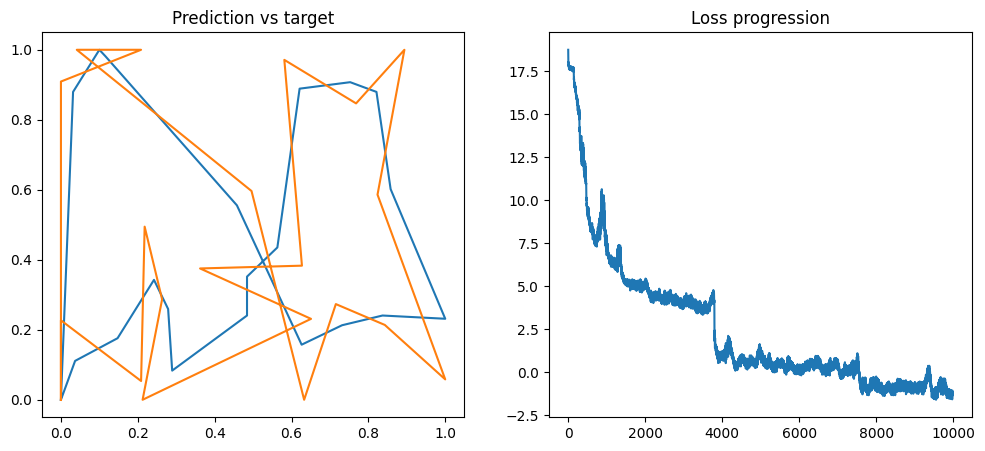

In [34]:
model = ConvNet(in_channels=1, conv1_out_channels=32, conv2_out_channels=64, fc1_out_features=128, output_size=44, additional_input_size=44, hidden_size=256).to(device)

criterion = CustomLossFunction().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters())

num_epochs = 1000
training_data_share = 0.9
n_datapoints = len(input_coordinates)
n_training = int(n_datapoints * training_data_share)

input_cords = torch.tensor(input_coordinates[:n_training], requires_grad=True).to(device)
distance_matrices_train = torch.tensor(distance_matrices[:n_training], requires_grad=True).to(device)
expected_out = torch.tensor(results_stacked[:n_training], requires_grad=False).to(device)
exptected_distances = torch.tensor(tmp_distances[:n_training], requires_grad=False).to(device)

# print(expected_out)

batches = 10
points_per_batch = n_training // batches
penalty_weight = 0.01

from IPython.display import clear_output

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show()
    
loss_progression = []
for epoch in range(num_epochs):  # Number of epochs
    for batch in range(batches):
        optimizer.zero_grad()  # Zero the parameter gradients
        
        outputs = model(distance_matrices_train[batch*points_per_batch:(batch+1)*points_per_batch], input_cords[batch*points_per_batch:(batch+1)*points_per_batch])  # Forward pass
        loss = criterion(outputs, expected_out[batch*points_per_batch:(batch+1)*points_per_batch], exptected_distances[batch*points_per_batch:(batch+1)*points_per_batch], penalty_weight = penalty_weight)  # Compute the loss
        # print(loss)

        loss.backward()  # Backward pass

        optimizer.step()  # Update the weights
        loss_progression.append(loss.item())

        if (epoch+1) % 10 == 0 and batch == batches-1:
            # print(loss.item())        
            clear_output(wait=True)
            # plt.show()
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')
            plot_number = 0
            sample_target = expected_out[batch*points_per_batch+plot_number].cpu()
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            ax1.plot(sample_target[0:22].cpu(), sample_target[22:].cpu(), label=f'Target {i}')
            ax1.plot(outputs[plot_number,0:22].cpu().detach().numpy(), outputs[plot_number,22:].cpu().detach().numpy(), label=f'Prediction {i}')
            ax1.set_title("Prediction vs target")
            # plt.figure("Loss")
            ax2.plot(10*np.log(loss_progression[20:]))
            ax2.set_title("Loss progression")

            plt.show()

from datetime import datetime
# Get the current date and time
now = datetime.now()
# Format the date and time as a string
current_time_str = now.strftime("%Y-%m-%d_%H%M%S")
torch.save(model.state_dict(), f'trained_models/model_trained_{current_time_str}.pth')


Evaluation Loss: 4.5782


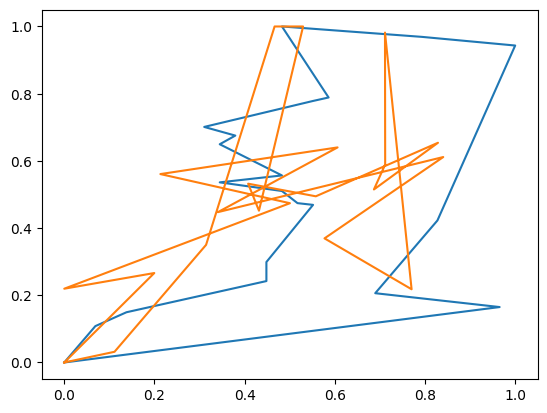

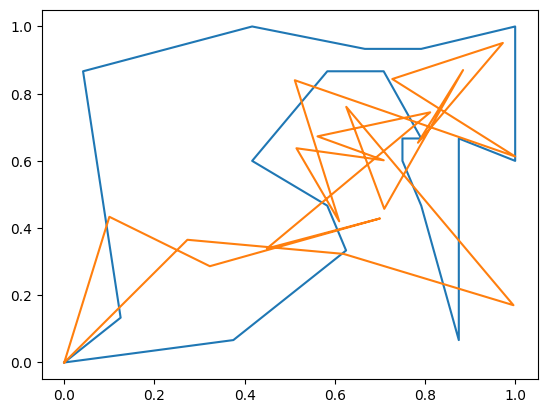

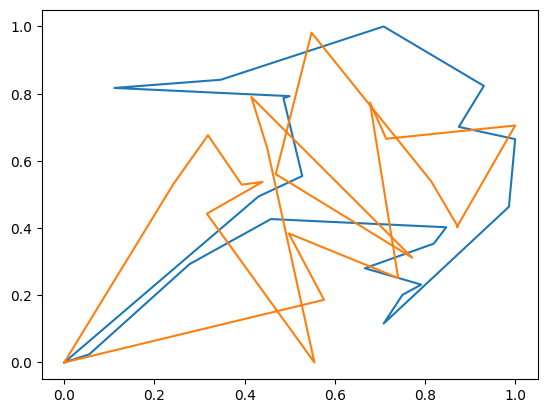

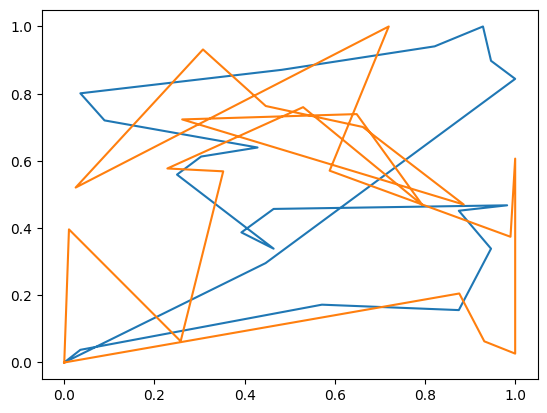

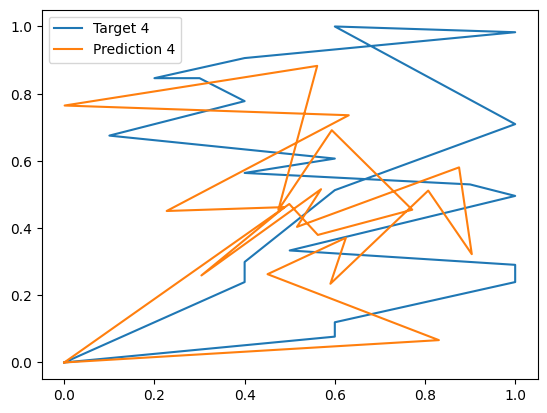

In [35]:
# Evaluating the model
num_eval = 5
model.eval()
with torch.no_grad():

    # eval_outputs = model(distance_matrices_train, input_cords)
    # eval_loss = criterion(eval_outputs, expected_out)

    sample_cords = input_coordinates[n_training:n_training+num_eval]
    sample_matrices = distance_matrices[n_training:n_training+num_eval]
    sample_targets = results_stacked[n_training:n_training+num_eval]
    sample_distances = tmp_distances[n_training:n_training+num_eval]

    sample_cords = torch.tensor(sample_cords, requires_grad=False).to(device)
    sample_matrices = torch.tensor(sample_matrices, requires_grad=False).to(device)
    sample_targets = torch.tensor(sample_targets, requires_grad=False).to(device)
    sample_distances = torch.tensor(sample_distances, requires_grad=False).to(device)

    # print(sample_cords)
    predictions = model(sample_matrices, sample_cords)
    eval_loss = criterion(predictions, sample_targets, sample_distances, penalty_weight = penalty_weight)
    print(f'Evaluation Loss: {eval_loss.item():.4f}')


    for i in range(num_eval):
        plt.figure(i)
        # print(sample_targets[i,0:22].cpu(), sample_targets[i,22:].cpu(), sample_targets)

        plt.plot(sample_targets[i,0:22].cpu(), sample_targets[i,22:].cpu(), label=f'Target {i}')
        plt.plot(predictions[i,0:22].cpu(), predictions[i,22:].cpu(), label=f'Prediction {i}')

plt.legend()
plt.show()